In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expi
from math import log10
import scipy as sp
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def fill_center_up(matrix_d,index,center):
  for i in index:
    k_up=int(center-i)
    if i%2==0:
      matrix_d[k_up,center]=i*L1+i*L3
    else:
      matrix_d[k_up,center]=(i+1)*L1+(i-1)*L3
  return matrix_d

def fill_center_down(matrix_d,index,center):
  for i in index:
    k_down=int(center+i)
    if i%2==0:
      matrix_d[k_down,center]=i*L1+i*L3
    else:
      matrix_d[k_down,center]=(i-1)*L1+(i+1)*L3
  return matrix_d 

def fill_center_right(matrix_d,index,center):
  for i in index:
    k_right=int(center+i)
    if i%2==0:
      matrix_d[center,k_right]=i*L4+i*L2
    else:
      matrix_d[center,k_right]=(i+1)*L4+(i-1)*L2
  return matrix_d    

def fill_center_left(matrix_d,index,center):
  for i in index:
    k_left=int(center-i)
    if i%2==0:
      matrix_d[center,k_left]=i*L4+i*L2 
    else:
      matrix_d[center,k_left]=(i-1)*L4+(i+1)*L2
  return matrix_d 

def fill_northeast(matrix_d,index,center):
  for i in index:
    for j in index:
      i=int(i)
      j=int(j)
      matrix_d[i-1,int(center+j)]=np.sqrt(matrix_d[i-1,int(center)]**2+matrix_d[int(center),int(center+j)]**2)
  return matrix_d   

def fill_southeast(matrix_d,index,center):
  for i in index:
    for j in index:
      i=int(i)
      j=int(j)
      matrix_d[int(center+i),int(center+j)]=np.sqrt(matrix_d[int(center+i),int(center)]**2+matrix_d[int(center),int(center+j)]**2)
  return matrix_d  

def fill_northwest(matrix_d,index,center):
  for i in index:
    for j in index:
      i=int(i)
      j=int(j)
      matrix_d[i-1,j-1]=np.sqrt(matrix_d[i-1,int(center)]**2+matrix_d[int(center),j-1]**2)
  return matrix_d    

def fill_southwest(matrix_d,index,center):
  for i in index:
    for j in index:
      i=int(i)
      j=int(j)
      matrix_d[int(center+i),j-1]=np.sqrt(matrix_d[int(center+i),int(center)]**2+matrix_d[int(center),j-1]**2)
  return matrix_d   

def setup_matrix_d(n_grids,rw,L1,L2,L3,L4):

  matrix_d=np.zeros((n_grids,n_grids))
  center=int((n_grids-1)/2)
  index=np.linspace(1,center,center)
  matrix_d[center,center]=rw

  matrix_d=fill_center_up(matrix_d,index,center)
  matrix_d=fill_center_down(matrix_d,index,center)
  matrix_d=fill_center_right(matrix_d,index,center)
  matrix_d=fill_center_left(matrix_d,index,center)
  matrix_d=fill_northeast(matrix_d,index,center)
  matrix_d=fill_northwest(matrix_d,index,center)
  matrix_d=fill_southwest(matrix_d,index,center)
  matrix_d=fill_southeast(matrix_d,index,center)
  #cmap = plt.cm.RdYlBu 
  #plt.imshow(matrix_d,cmap=cmap)
  #plt.colorbar()
  return matrix_d

def calc_dp(k,por,h,ct,Bo,visc,q  ,skin,t,matrix_d,n_grids,center):
  kp=(19.03*q*Bo*visc/(k*h))
  matrix_p=np.zeros((n_grids,n_grids))

  for i in range(n_grids):
    for j in range(n_grids):
      matrix_p[i,j]=0.5*kp*-expi(-(0.25*por*visc*ct*matrix_d[i,j]**2)/(0.0003484*k*t))
  matrix_p[center,center]=kp*(-0.5*expi(-(0.25*por*visc*ct*matrix_d[center,center]**2)/(0.0003484*k*t))+skin)
  return np.sum(matrix_p)

def create_t(start,end,samples_per_decade):
  ndecades = log10(end) - log10(start)
  npoints = int(ndecades) * samples_per_decade
  points = np.logspace(log10(start), log10(end), num=npoints, endpoint=True, base=10)
  return points

def create_dpu(t_dec,k,por,h,ct,Bo,visc,q,skin,matrix_d,n_grids,center):
  dp=[]

  for t in t_dec:
    dp.append(calc_dp(k,por,h,ct,Bo,visc,q,skin,t,matrix_d,n_grids,center))
  dp=np.array(dp)
  return dp

def calc_derivative(time, pressure, factor_L):
    # inicializacao do fator_L e variaveis secundarias
    
    n_points = len(time)
    deriv_pressure = []
    deriv_time = []
    i = 0
    while i < n_points:
        t1 = time[i]
        p1 = pressure[i]
        # encontrar o ti-1
        j = i
        while j > 0:
            if time[j] < t1 / np.exp(factor_L):
                break
            j -= 1
        # encontrar o ti+1
        k = i
        while k < n_points-1:
            if time[k] > t1 * np.exp(factor_L):
                break
            k += 1

        p0, p2 = pressure[j], pressure[k]
        t0, t2 = time[j], time[k]
        log_t0 = np.log(t0) if t0 != 0 else 0
        log_t1 = np.log(t1) if t1 != 0 else 0
        log_t2 = np.log(t2) if t2 != 0 else 0
        w1 = log_t1 - log_t0
        w2 = log_t2 - log_t1
        m1 = (p1-p0)/w1 if w1 > 0 else 0
        m2 = (p2-p1)/w2 if w2 > 0 else 0
        tdpdt = m1*w2/(w1+w2) + m2*w1/(w1+w2)
        # calculo da derivada
        deriv_pressure.append(tdpdt)
        i+=1
        # retorna ambos os arrays (t e dpdt) como arrays numpy
    return np.array(deriv_pressure)

def unit_response(start,end,samples_per_decade,k,por,h,ct,Bo,visc,q,skin,matrix_d,n_grids):
  t_dec=create_t(start,end,samples_per_decade)
  dp_u=create_dpu(t_dec,k,por,h,ct,Bo,visc,q,skin,matrix_d,n_grids)
  der_u=calc_derivative(t_dec,dpu,0.0)
  dp_u=dp_u/q
  der_u=der_u/q
  return t_dec,dp_u,der_u 

def kernel_conv(k,por,h,ct,Bo,visc,q,skin,t,matrix_d,n_grids,center):
  dp_u=create_dpu(t,k,por,h,ct,Bo,visc,q,skin,matrix_d,n_grids,center) 
  kernel=dp_u/q
  return kernel 

def toeplitz_matrix(qk): 
  padding = np.zeros(qk.shape[0] - 1, qk.dtype)
  first_col = qk
  first_row = np.r_[qk[0], padding]
  qkH = sp.linalg.toeplitz(first_col, first_row)
  return  qkH  

def time_and_rate(t_schedule,q_schedule,n_points):
  t_schedule=np.array(t_schedule)
  q_schedule=np.array(q_schedule)
  tk=np.linspace(0.001,np.sum(t_schedule),n_points)
  end_points=np.cumsum(t_schedule)
  end_points=np.r_[0.0,end_points]
  i=0
  qk=np.zeros(tk.shape[0])
  while i<end_points.shape[0]-1:
    index=np.where((tk>=end_points[i]) & (tk<=end_points[i+1]))
    qk[index]=q_schedule[i]
    i=i+1  
  return tk,qk

# **Parameters**

In [ ]:
k=564.3
por=0.2
h=25.0
ct=0.00020833
Bo=1.7497
visc=0.272591
pi=537.4

skin=3.8
rw=0.108

# even (L2,L4) horizontal, odd (L1,L3) vertical
L1=244.0
L2=700.0
L3=592.8
L4=2000.0
#---------------------------------------------------
n_grids=41
center=int((n_grids-1)/2) 
q_ref=15.9
#---------------------------------------------------
t_schedule=[10.0,24.0,50.0,48.0]
q_schedule=[200.0,0.0,200.0,0.0]
n_points=1000
#---------------------------------------------------
# numerical set-ups
matrix_d=setup_matrix_d(n_grids,rw,L1,L2,L3,L4)
tk,qk=time_and_rate(t_schedule,q_schedule,n_points)

In [ ]:
# import sys
# sys.path.append('drive/My Drive/Colab Notebooks')
# fid = 'drive/My Drive/Colab Notebooks/teste.xlsx'

# df = pd.read_excel(fid)
# tk = df['t'].values
# tk[0]=0.001
# qk = df['q'].values
# p_field = df['p'].values

# **Simulation**

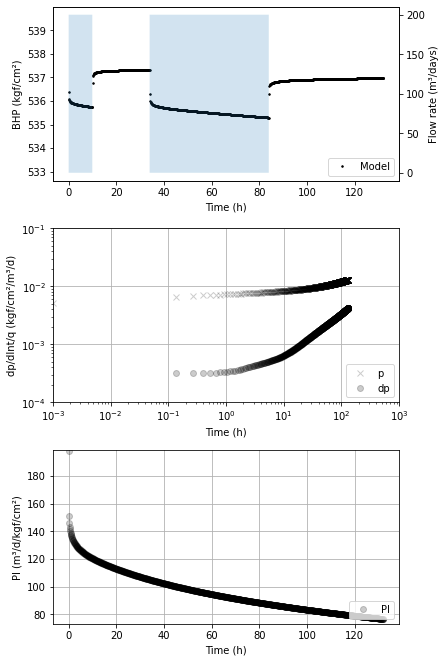

In [ ]:
# create unit-response array
dp_u=create_dpu(tk,k,por,h,ct,Bo,visc,q_ref,skin,matrix_d,n_grids,center)
der_u=calc_derivative(tk, dp_u/q_ref, 0.0)
#t_dec,dp_u,der_u=unit_response(start,end,samples_per_decade,k,por,h,ct,Bo,visc,q_ref,skin,matrix_d,n_grids)

# convolution
kernel=kernel_conv(k,por,h,ct,Bo,visc,q_ref,skin,tk,matrix_d,n_grids,center)
ip=1/kernel
kernel=toeplitz_matrix(kernel)
dpwf = np.dot(kernel,np.diff(np.r_[0.0,qk]))
pwf=pi-dpwf

#---------------------------------------------------------------------------------
# plots
fig, axes = plt.subplots(3,1,figsize=(6.3, 9.3))
#axes[0].plot(tk, p_field, 'ok', ms=3, markerfacecolor='None', label='Field Data')
axes[0].plot(tk, pwf, 'ko', ms=1.5, label='Model')
axes[0].grid(0)
axes[0].set_ylim([0.995*pwf.min(),1.005*pwf.max()])
axes[0].set_ylabel('BHP (kgf/cm²)')
axes[0].set_xlabel('Time (h)')
axes[0].legend(loc='lower right')

twin = axes[0].twinx()
twin.fill_between(tk, qk, alpha=0.2, step='pre')
twin.set_ylabel('Flow rate (m³/days)')
twin.grid(0)

axes[1].loglog(tk,dp_u/q_ref, 'kx',ms=6.0,label='p',alpha=0.2)
axes[1].loglog(tk,der_u, 'ko',ms=6.0,label='dp',alpha=0.2)
axes[1].set_xlim([1e-3, 1e3])
axes[1].set_ylim([1e-4, 1e-1])
axes[1].set_ylabel('dp/dlnt/q (kgf/cm²/m³/d)')
axes[1].set_xlabel('Time (h)')
#axes[1].set_aspect('equal', 'datalim')
axes[1].legend(loc='lower right')
axes[1].grid()

axes[2].plot(tk,ip, 'ko',ms=6.0,label='PI',alpha=0.2)
axes[2].set_ylim([0.955*ip.min(),1.005*ip.max()])
axes[2].set_ylabel('PI (m³/d/kgf/cm²)')
axes[2].set_xlabel('Time (h)')
#axes[1].set_aspect('equal', 'datalim')
axes[2].legend(loc='lower right')
axes[2].grid()

plt.tight_layout()